# Import statements


In [1]:
import os

import pandas as pd

from pymatgen.core.structure import Molecule
from pymatgen.io.lammps.outputs import parse_lammps_log

from mdproptools.dynamical.diffusion import Diffusion
from mdproptools.utilities.fluctuations import plot_fluctuations
from mdproptools.structural.cluster_analysis import (
    get_clusters,
    get_unique_configurations,
)

# System overview 

The system we will use for cluster analysis contains 0.5 M Mg(TFSI)2 in DME. In this notebook, we will be calculating the radial distribution function (RDF) and the coordination number of the Mg2+ ion with other atom types in the system. In addition, we will be extracting the first solvation shell around the cation and processing these clusters to obtain the top unique configurations that make up around 80% of the Mg2+ solvation environment in this system. 


# Initialization


In [2]:
dump_files_pattern = "dump.nvt.*.dump"
outputs_dir = "../data/mg_tfsi_dme"
dump_files = os.path.join(f"{outputs_dir}/{dump_files_pattern}")
npt_log_file = os.path.join(f"{outputs_dir}/log.mixture_npt")
nvt_log_file = os.path.join(f"{outputs_dir}/log.mixture_nvt")
# Create pymatgen Molecule objects for each molecule in the system and
# place them in a list in the same order they appear in the LAMMPS dump file
dme = Molecule.from_file("../data/mg_tfsi_dme/dme.pdb")
tfsi = Molecule.from_file("../data/mg_tfsi_dme/tfsi.pdb")
mg = Molecule.from_file("../data/mg_tfsi_dme/mg.pdb")
molecules = [dme, tfsi, mg]

# Define the names of the molecules in the system and the atom types that
# will be used to identify the coordination environment of the Mg2+ ion when
# extracting the first solvation shell
mol_names = ["dme", "tfsi", "mg"]
type_coord_atoms = ["O", "N", "Mg"]

# Since the dump files do not contain the element property, we need to specify
# the elements in the system in the order they appear in the LAMMPS dump file
# so that the correct atom types can be assigned to each atom when extracting
# the first solvation shell
elements = ["O", "C", "H", "N", "S", "O", "C", "F", "Mg"]

# Specify the atom type of the atom of interest (Mg2+ ion) and the cutoff radius
# to be used when extracting the first solvation shell
atom_type = 9
r_cut = 2.3
max_force = 0.75

# Specify the number of molecules in the system and the number of atoms per
# molecule in the same order they appear in the LAMMPS dump file
num_mols = [591, 66, 33]
num_atoms_per_mol = [16, 15, 1]
mass = [
    16.000,
    12.010,
    1.008,
    14.010,
    32.060,
    16.000,
    12.010,
    19.000,
    24.305,
]

# Specify whether the full trajectory should be used for cluster analysis
# or just a single frame
full_trajectory = False
frame = 50  # If full_trajectory is True, specify the frame number to be used for cluster analysis

# We will be using the default atom types assigned by LAMMPS for this system,
# so we will not be altering the atom types, atom_type 8 corresponds to the Mg2+ ion
alter_atom_types = False

# All files will be saved in working_dir, which defaults to the current
# working directory if not specified
working_dir = None

timestep = 1
units = "real"

# System Fluctuations
Here, we will use the log file from the NPT run to plot the fluctuations of various properties of interest of the system. This is an important step to ensure that the system has equilibrated and none of the properties like temperature or pressure are fluctuating wildly before proceeding with further analysis.

Temp: mean = 298.1655698001, std = 2.3657322430361725
Press: mean = 8.744043661754121, std = 501.0384974795734
TotEng: mean = 3509.8657754122937, std = 215.90649043162605
PotEng: mean = -5802.717911244377, std = 203.4603001333515
KinEng: mean = 9312.583687456272, std = 73.88874529034626
Volume: mean = 117908.3472113943, std = 1042.6796596819754
Density: mean = 1.0218597295202398, std = 0.008556584588785833
Lx: mean = 49.03556657971015, std = 0.1418008817264681
E_bond: mean = 3137.3364088805597, std = 80.77639271925734
E_angle: mean = 4618.210226316841, std = 105.59895121399602
E_dihed: mean = 1028.4692388355822, std = 32.343600372237425
E_pair: mean = -14586.733786606697, std = 92.24027657477477
E_vdwl: mean = -2690.2185935532234, std = 58.15760128982688
E_coul: mean = 10601.128957021489, std = 63.397885772659265
E_long: mean = -22497.644136931533, std = 11.182174389502324
Fnorm: mean = 3316.967816777611, std = 76.19360015037984


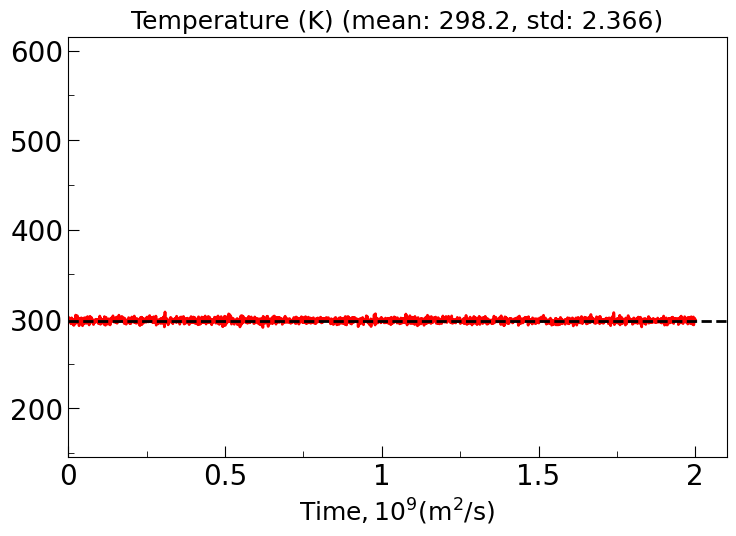

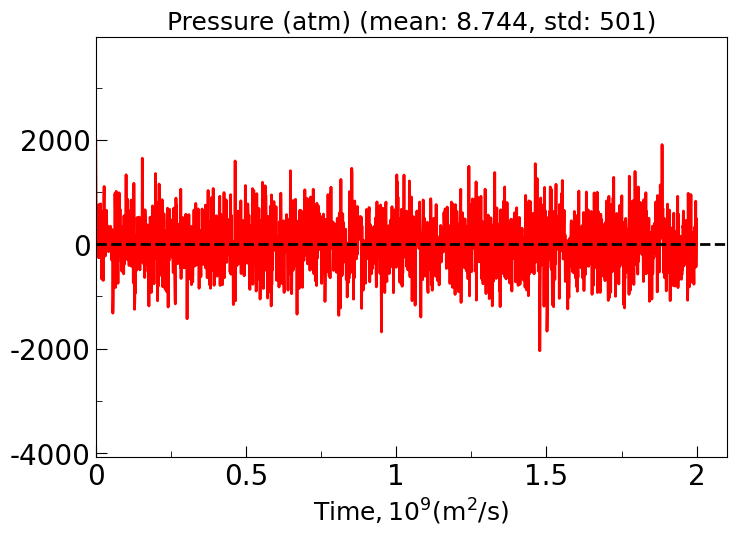

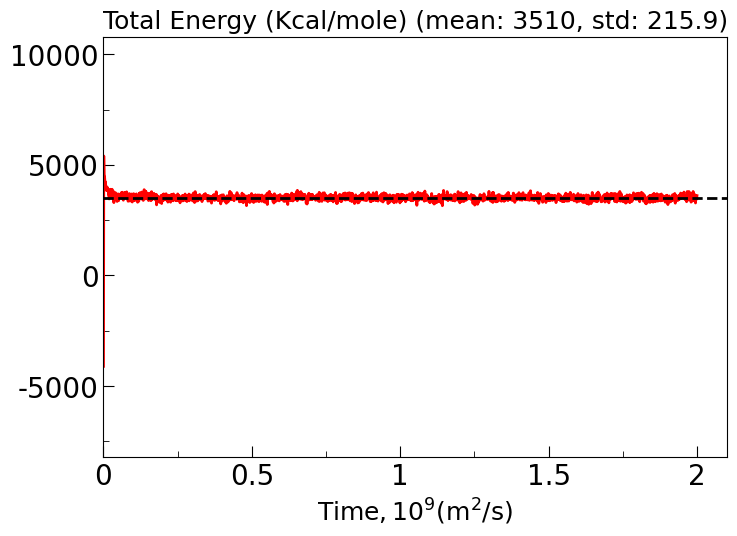

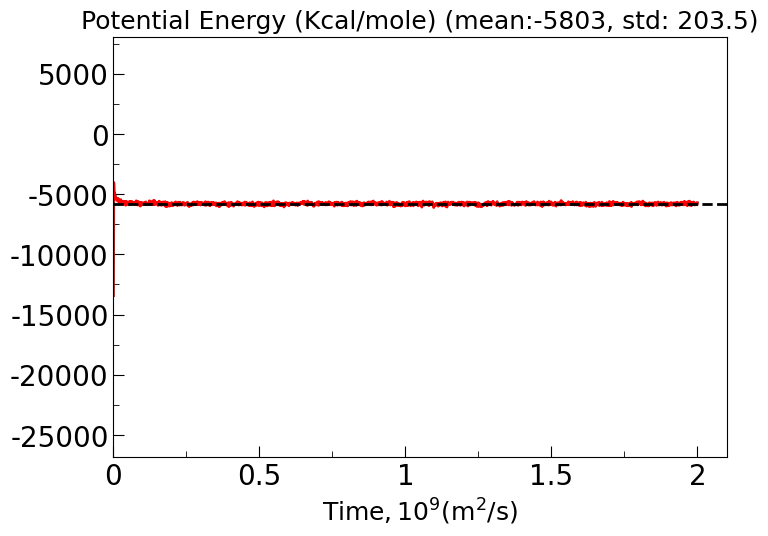

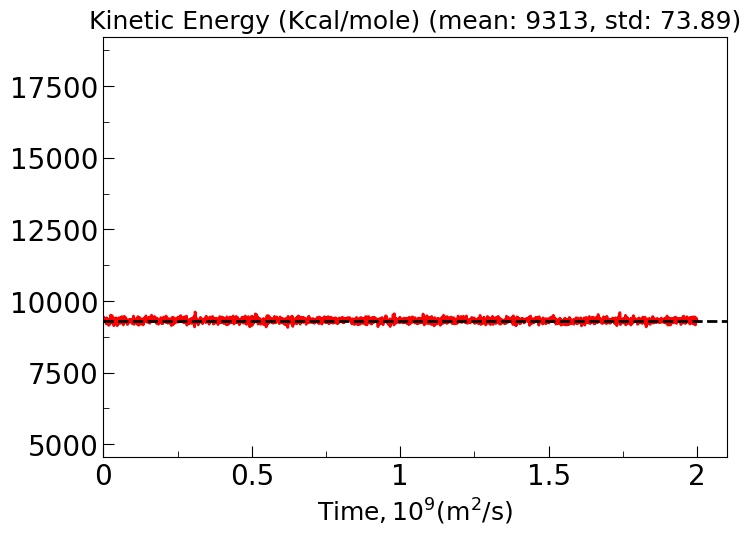

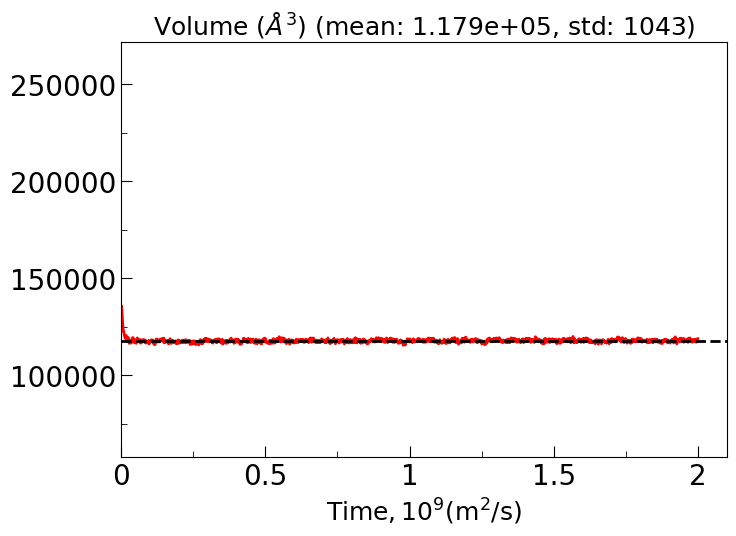

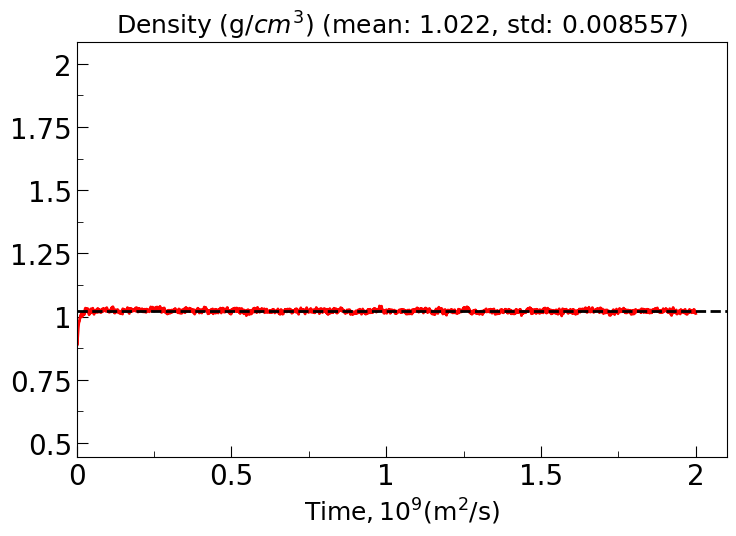

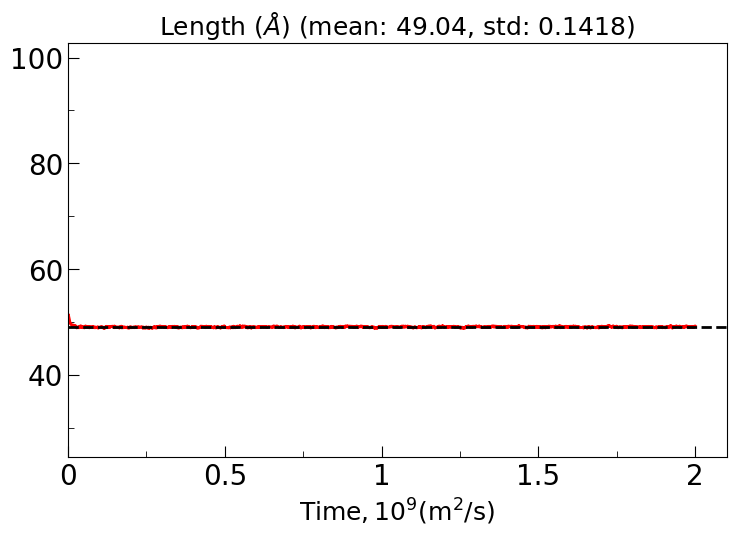

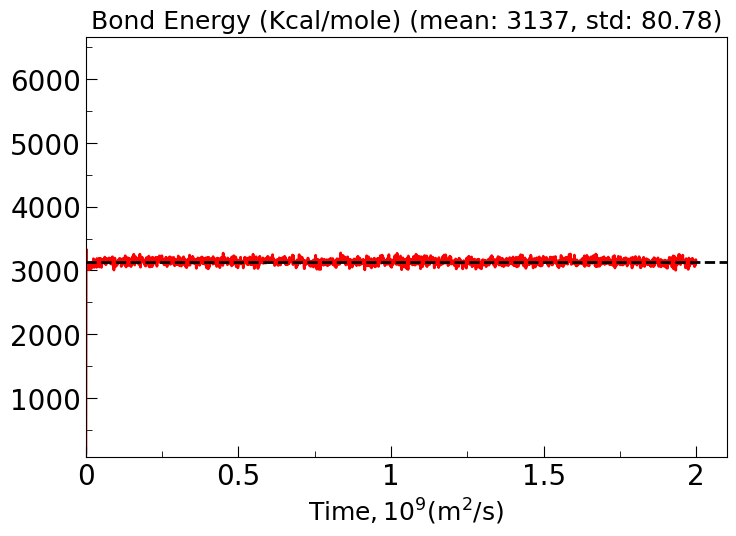

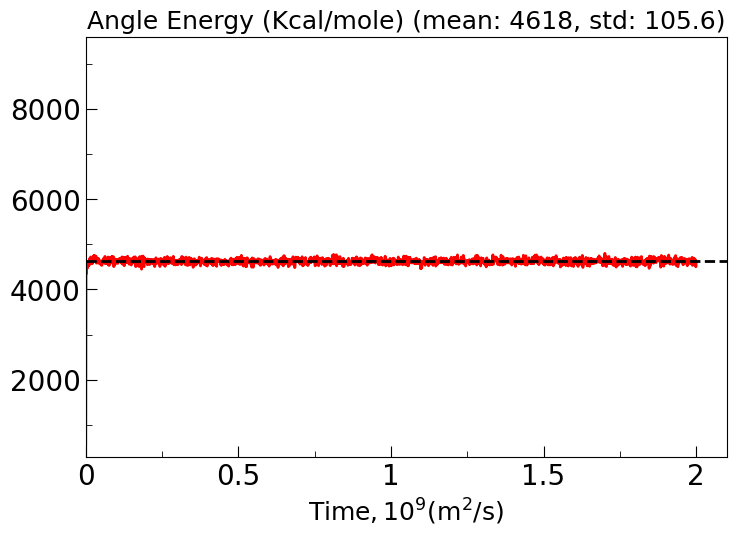

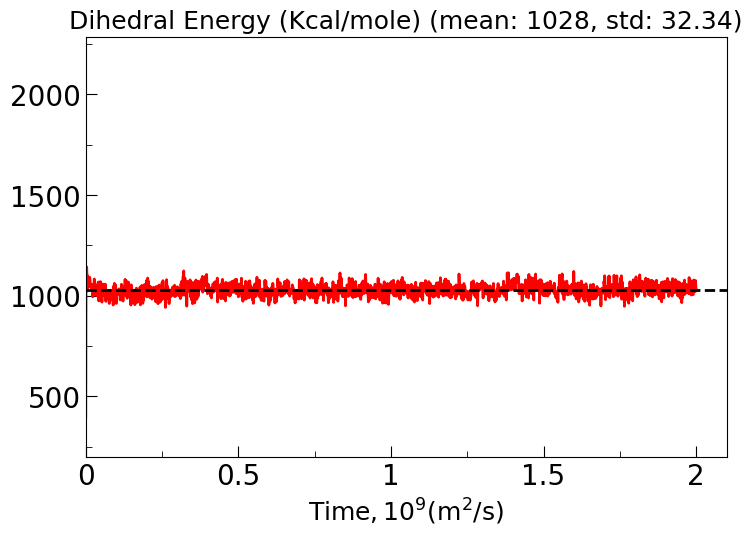

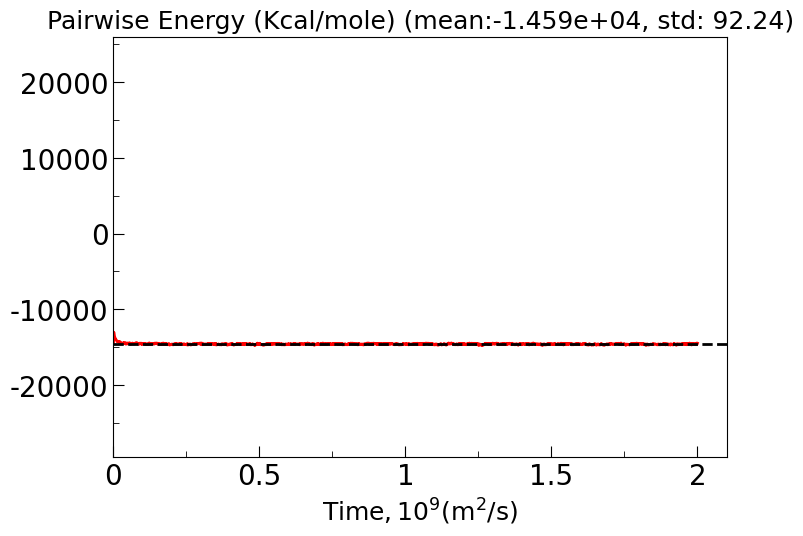

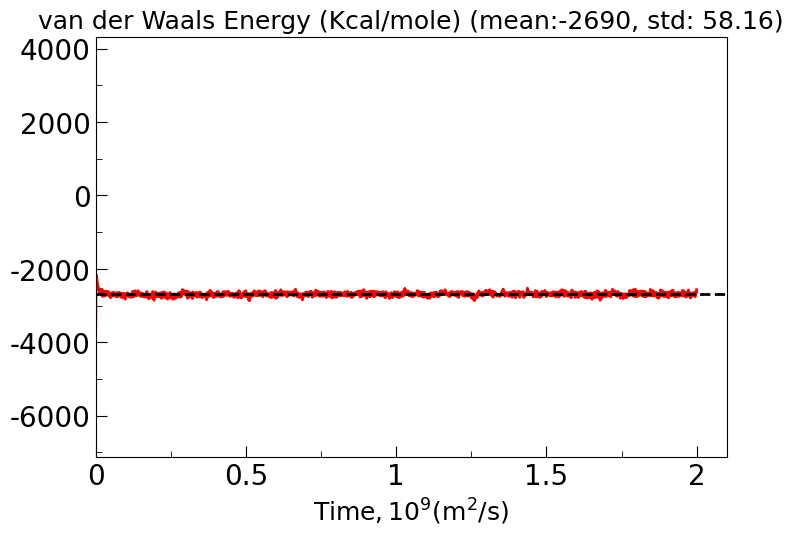

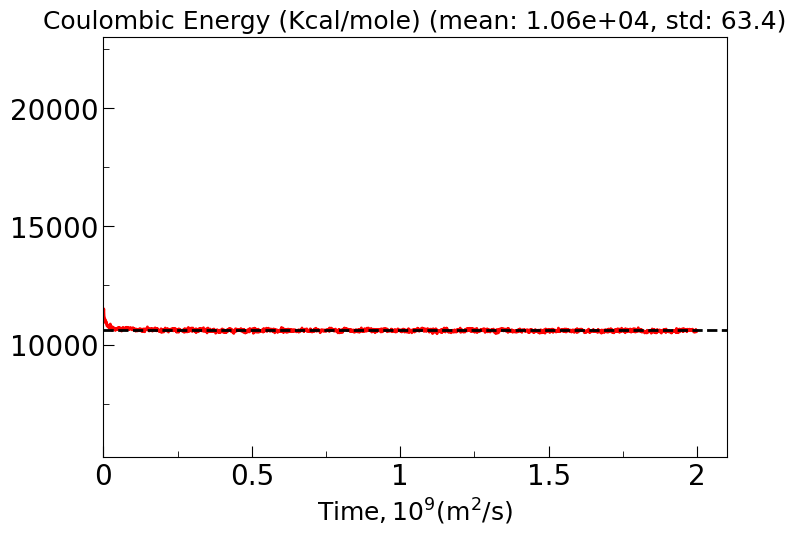

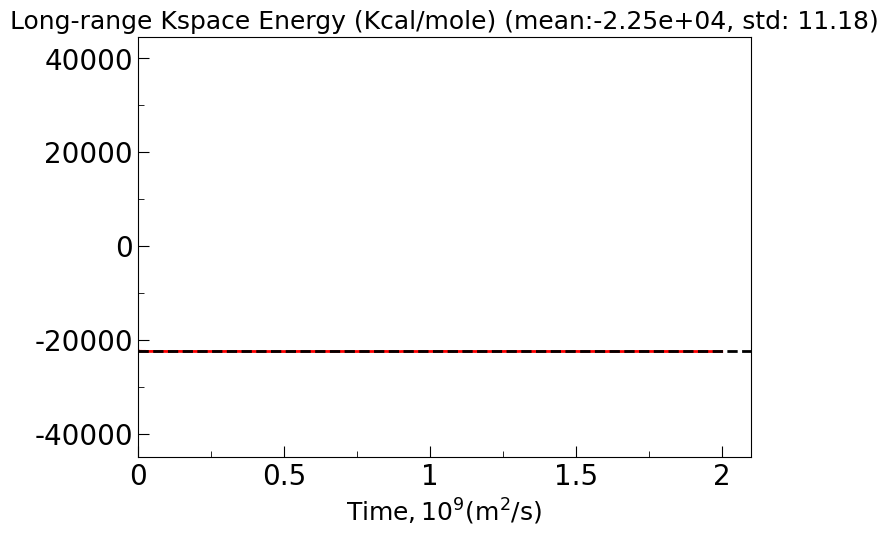

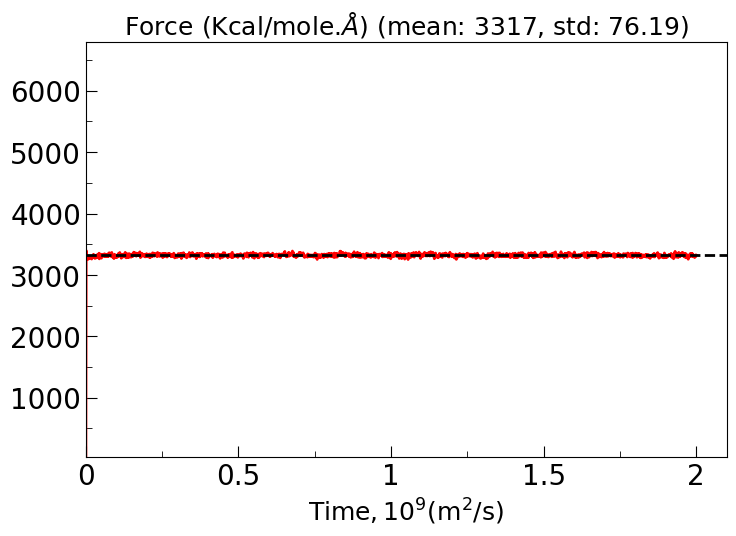

In [3]:
npt_log = parse_lammps_log(npt_log_file)
props = {
    "Temp": ["Temperature (K)", "temperature_fluctuations"],
    "Press": ["Pressure (atm)", "pressure_fluctuations"],
    "TotEng": ["Total Energy (Kcal/mole)", "total_energy_fluctuations"],
    "PotEng": ["Potential Energy (Kcal/mole)", "potential_energy_fluctuations"],
    "KinEng": ["Kinetic Energy (Kcal/mole)", "kinetic_energy_fluctuations"],
    "Volume": ["Volume ($\AA^3$)", "volume_fluctuations"],
    "Density": ["Density (g/$cm^3$)", "density_fluctuations"],
    "Lx": ["Length ($\AA$)", "length_fluctuations"],
    "E_bond": ["Bond Energy (Kcal/mole)", "bond_energy_fluctuations"],
    "E_angle": ["Angle Energy (Kcal/mole)", "angle_energy_fluctuations"],
    "E_dihed": ["Dihedral Energy (Kcal/mole)", "dihedral_energy_fluctuations"],
    "E_pair": ["Pairwise Energy (Kcal/mole)", "pairwise_energy_fluctuations"],
    "E_vdwl": ["van der Waals Energy (Kcal/mole)", "vdwl_energy_fluctuations"],
    "E_coul": ["Coulombic Energy (Kcal/mole)", "coulombic_energy_fluctuations"],
    "E_long": [
        "Long-range Kspace Energy (Kcal/mole)",
        "longrange_energy_fluctuations",
    ],
    "Fnorm": ["Force (Kcal/mole.$\AA$)", "force_fluctuations"],
}

for prop, (title, filename) in props.items():
    prop_mean, prop_std = plot_fluctuations(npt_log[0], prop, title, filename)

# RDF analysis

# Coordination number analysis


# Cluster analysis


## Get clusters


In [4]:
num_clusters = get_clusters(
    filename=dump_files,
    atom_type=atom_type,
    r_cut=r_cut,
    num_mols=num_mols,
    num_atoms_per_mol=num_atoms_per_mol,
    full_trajectory=full_trajectory,
    frame=frame,
    elements=elements,
    alter_atom_types=alter_atom_types,
    max_force=max_force,
    working_dir=working_dir,
)

Processing dump files: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


## Get unique configurations

In [5]:
clusters_df, conf_df = get_unique_configurations(
    cluster_pattern="Cluster_*.xyz",
    r_cut=r_cut,
    molecules=molecules,
    type_coord_atoms=type_coord_atoms,
    working_dir=working_dir,
    find_top=True,
    perc=None,
    cum_perc=100,
    mol_names=mol_names,
    zip=True,
)

Processing cluster files: 100%|██████████| 33/33 [00:00<00:00, 110.32it/s]


In [6]:
top_conf_df = pd.read_csv("top_conf.csv")
top_conf_df

,num_dme,num_tfsi,num_mg,atoms_dme,atoms_tfsi,atoms_mg,count,%,cluster
0,2,2,0,2O:2O,1O:1O,NaN,20,60.606061,Cluster_0_20.xyz
1,3,1,0,1O:2O:2O,1O,NaN,8,24.242424,Cluster_0_26.xyz
2,3,0,0,2O:2O:2O,NaN,NaN,3,9.090909,Cluster_0_27.xyz
3,1,4,0,2O,1O:1O:1O:1O,NaN,1,3.030303,Cluster_0_15.xyz
4,2,3,0,1O:2O,1O:1O:1O,NaN,1,3.030303,Cluster_0_02.xyz


The above results indicate that around 60% of the Mg2+ solvation environment is made up of the 2 DME molecules contributing 2 oxygen atoms and 2 TFSI anions contributing 1 oxygen atom each. The second most frequent solvation shell consists of 3 DME molecules, two of which contribute 2 ether oxygens each and one DME contributing 1 oxygen, along with 1 TFSI anion contributing 1 oxygen atom. Finally, the third most frequent solvation shell consists of 3 DME molecules contributing 2 ether oxygens each in bidentate configuration. To visualize these clusters, you can open the conf_*.xyz files in this directory in a visualization software such as VMD or Avogadro.  

# Diffusion analysis 

/gpfs/projects/RajputGroup/ratwi/environment/mdproptools/mdproptools/dynamical/diffusion.py:399: UserWarning: AutoMinorLocator does not work with logarithmic scale
  figure.tight_layout()
/gpfs/projects/RajputGroup/ratwi/environment/mdproptools/mdproptools/dynamical/diffusion.py:403: UserWarning: AutoMinorLocator does not work with logarithmic scale
  pad_inches=0.1,


Diffusion results written to a .csv file.


,diffusion (m2/s),std,R2
dme,1.330522e-09,2.164493e-12,0.999735
tfsi,1.976415e-10,2.162102e-12,0.988174
mg,1.585219e-10,1.821829e-12,0.986964


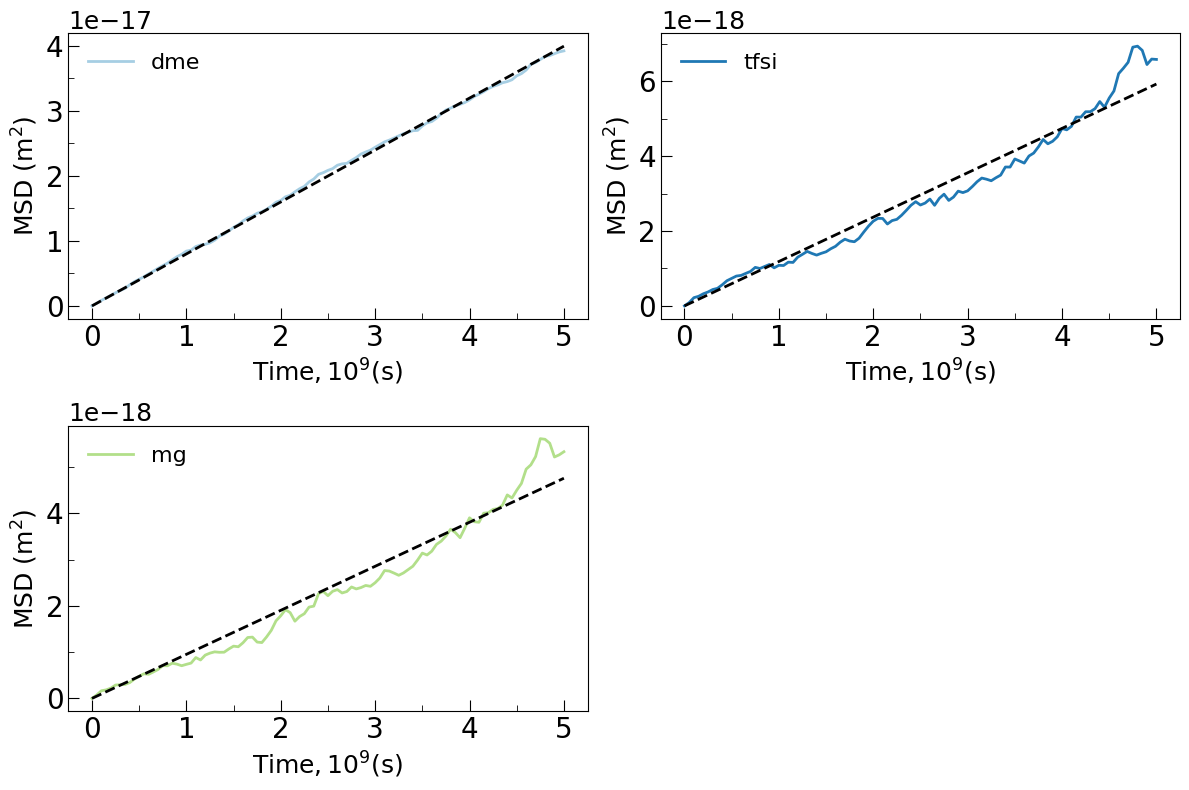

/gpfs/projects/RajputGroup/ratwi/environment/condaenv/mispr_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


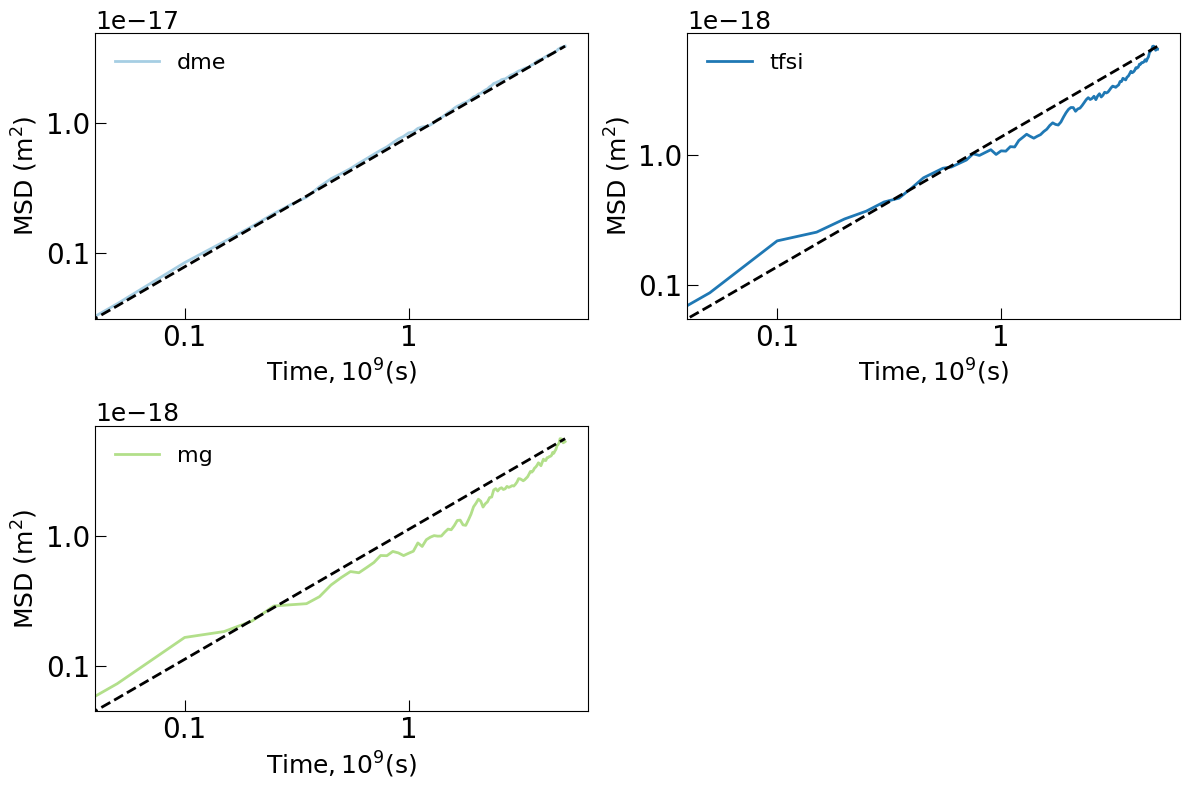

In [9]:
d = Diffusion(
    timestep=timestep, units=units, outputs_dir=outputs_dir, diff_dir=working_dir
)

msd, msd_all, msd_int = d.get_msd_from_dump(
    filename=dump_files_pattern,
    msd_type="com",
    num_mols=num_mols,
    num_atoms_per_mol=num_atoms_per_mol,
    mass=mass,
    com_drift=True,
    avg_interval=True,
    tao_coeff=4,
)

diffusion = d.calc_diff(
    msd=msd,
    initial_time=None,
    final_time=None,
    dimension=3,
    diff_names=mol_names,
    save=True,
    plot=True,
)
diffusion

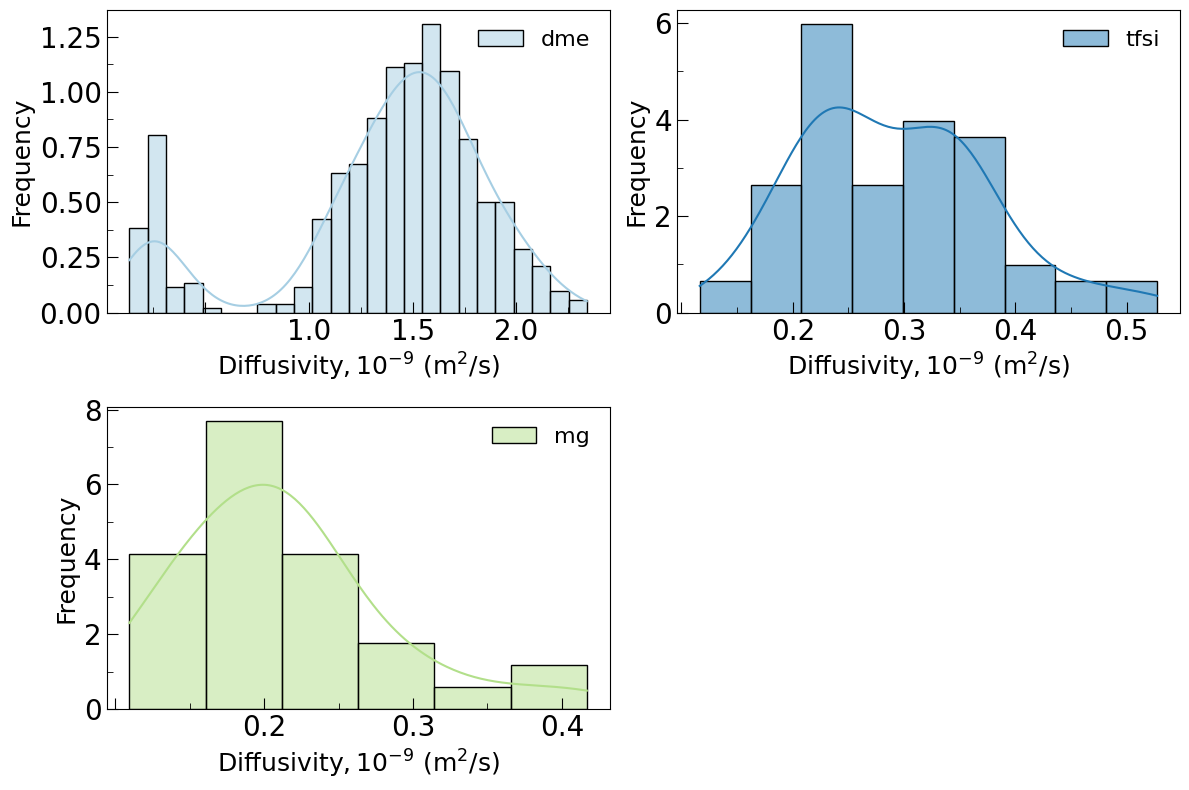

In [10]:
diff_dist = d.get_diff_dist(
    msd_int=msd_int,
    dump_freq=50000,
    dimension=3,
    tao_coeff=4,
    plot=True,
    diff_names=mol_names,
)